# Lab 2 – Exploratory Data Analysis (EDA) and Cleaning
**Author:** Anam Ayyub  
**Dataset:** Derm7pt (meta.csv)  
**Goal:** Explore metadata, clean features, prepare for baselines


In [11]:
# Block 1: imports, plotting style, and file paths
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid", context="notebook")

# Dataset paths
DATASET_PATH = r"C:\Users\anama\Documents\Group_8\Dataset\DERM7PT"
META_DIR = os.path.join(DATASET_PATH, "meta")
META_FILE = os.path.join(META_DIR, "meta.csv")

# Output filenames
CLEAN_FILE = os.path.join(META_DIR, "features.csv")
Y_BINARY_FILE = os.path.join(META_DIR, "target_binary.csv")
Y_MULTI_FILE = os.path.join(META_DIR, "target_multiclass.csv")
MISSINGNESS_FILE = os.path.join(META_DIR, "missingness_report.csv")
SUMMARY_FILE = os.path.join(META_DIR, "dataset_summary.csv")

os.makedirs(META_DIR, exist_ok=True)

assert os.path.exists(DATASET_PATH), f"Dataset path not found: {DATASET_PATH}"
assert os.path.exists(META_FILE), f"Metadata file not found: {META_FILE}"

print("Paths verified.")
print("Dataset folder:", DATASET_PATH)
print("Metadata file:", META_FILE)



Paths verified.
Dataset folder: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT
Metadata file: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\meta.csv


In [12]:
# Block 2: load the raw metadata and print brief checks
df = pd.read_csv(META_FILE)
print("Loaded meta.csv shape:", df.shape)
print("Columns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head().to_string(index=False))


Loaded meta.csv shape: (1011, 19)
Columns: ['case_num', 'diagnosis', 'seven_point_score', 'pigment_network', 'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules', 'blue_whitish_veil', 'vascular_structures', 'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex', 'management', 'clinic', 'derm', 'case_id', 'notes']

First 5 rows:
 case_num            diagnosis  seven_point_score pigment_network streaks      pigmentation regression_structures dots_and_globules blue_whitish_veil vascular_structures level_of_diagnostic_difficulty elevation    location    sex management         clinic           derm case_id notes
        1 basal cell carcinoma                  0          absent  absent            absent                absent            absent            absent          arborizing                         medium   nodular     abdomen female   excision NEL/NEL025.JPG NEL/Nel026.jpg     NaN   NaN
        2 basal cell carcinoma                  1          absent  abse

In [13]:
# Block 3: check for expected columns and minor non-destructive cleanup
expected_present = [
    "case_num", "diagnosis", "seven_point_score", "pigment_network", "streaks",
    "pigmentation", "regression_structures", "dots_and_globules", "blue_whitish_veil",
    "vascular_structures", "level_of_diagnostic_difficulty", "elevation", "location",
    "sex", "management", "clinic", "derm"
]
missing_expected = [c for c in expected_present if c not in df.columns]
print("Missing expected columns (if any):", missing_expected)

possible_id_cols = [c for c in ["case_id", "notes", "image_path", "image_id", "case_num"] if c in df.columns]
print("Identifier / path-like columns found (kept for provenance):", possible_id_cols)


Missing expected columns (if any): []
Identifier / path-like columns found (kept for provenance): ['case_id', 'notes', 'case_num']


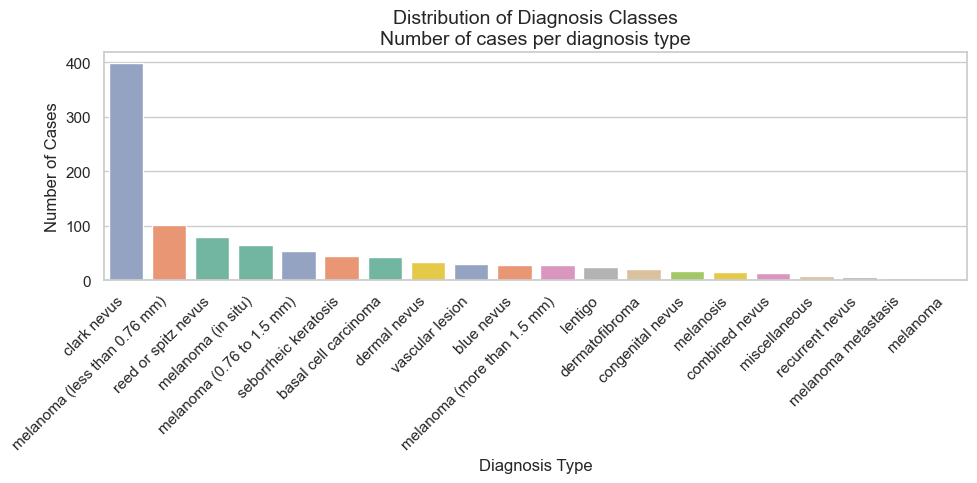


Diagnosis class counts:
diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular lesion                  29
blue nevus                       28
melanoma (more than 1.5 mm)      28
lentigo                          24
dermatofibroma                   20
congenital nevus                 17
melanosis                        16
combined nevus                   13
miscellaneous                     8
recurrent nevus                   6
melanoma metastasis               4
melanoma                          1


In [14]:
# Block 4: diagnosis class distribution
plt.figure(figsize=(10, 5))
sns.countplot(
    x="diagnosis",
    data=df,
    order=df["diagnosis"].value_counts().index,
    hue=df["diagnosis"],
    palette="Set2",
    dodge=False
)
plt.title("Distribution of Diagnosis Classes\nNumber of cases per diagnosis type", fontsize=14)
plt.xlabel("Diagnosis Type", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

print("\nDiagnosis class counts:")
print(df["diagnosis"].value_counts().to_string())


Saved missingness report to: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\missingness_report.csv
Top features by missing count:
                                missing_count  missing_rate
notes                                    1002      0.991098
case_id                                   984      0.973294
case_num                                    0      0.000000
seven_point_score                           0      0.000000
diagnosis                                   0      0.000000
pigment_network                             0      0.000000
streaks                                     0      0.000000
dots_and_globules                           0      0.000000
blue_whitish_veil                           0      0.000000
pigmentation                                0      0.000000
regression_structures                       0      0.000000
level_of_diagnostic_difficulty              0      0.000000
vascular_structures                         0      0.000000
elevation              

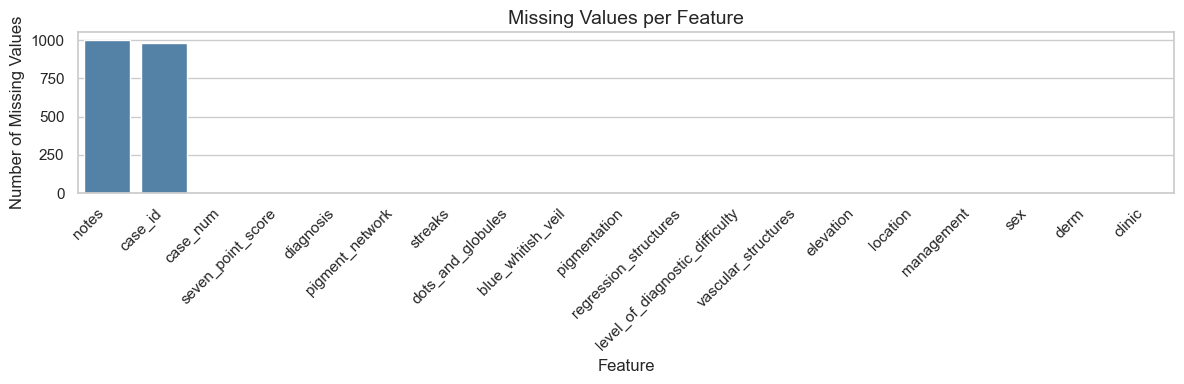

In [15]:
# Block 5: compute, save, and plot missingness per feature
missing = df.isnull().sum().sort_values(ascending=False)
missing_df = missing.rename("missing_count").to_frame()
missing_df["missing_rate"] = missing_df["missing_count"] / len(df)
missing_df.to_csv(MISSINGNESS_FILE)

print("Saved missingness report to:", MISSINGNESS_FILE)
print("Top features by missing count:")
print(missing_df.head(15).to_string())

plt.figure(figsize=(12, 4))
sns.barplot(x=missing.index, y=missing.values, color="steelblue")
plt.title("Missing Values per Feature", fontsize=14)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Numeric columns detected: ['case_num', 'seven_point_score']


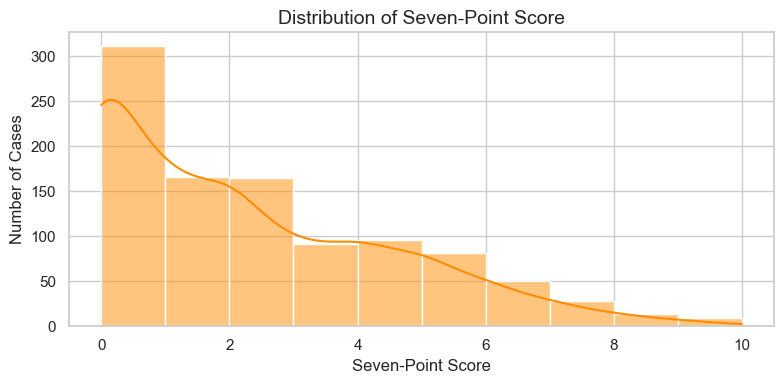

In [16]:
# Block 6: numeric columns summary and seven_point_score distribution
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numeric columns detected:", numeric_cols)

if "seven_point_score" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df["seven_point_score"].dropna(), bins=10, kde=True, color="darkorange")
    plt.title("Distribution of Seven-Point Score", fontsize=14)
    plt.xlabel("Seven-Point Score", fontsize=12)
    plt.ylabel("Number of Cases", fontsize=12)
    plt.tight_layout()
    plt.show()


Top correlations with seven_point_score:
case_id_te_tmp              0.826969
derm_te_tmp                 0.687729
clinic_te_tmp               0.687729
dots_and_globules_te_tmp    0.677864
streaks_te_tmp              0.671800


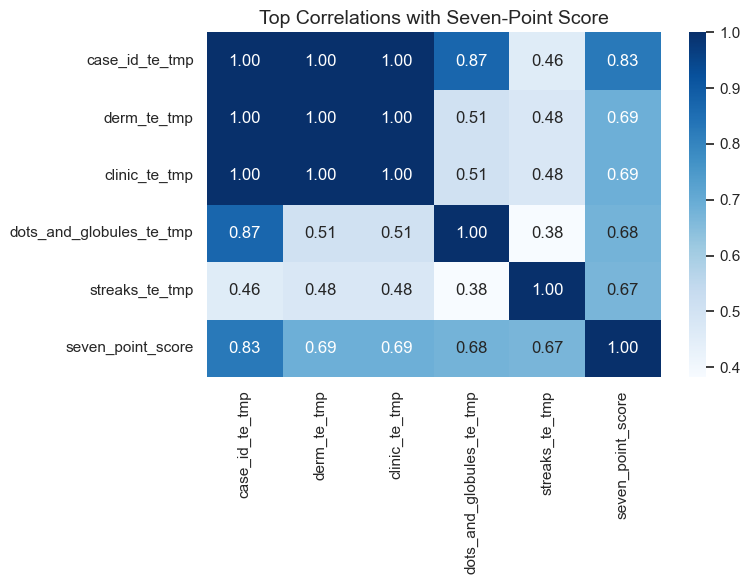

In [17]:
# Block 7: correlation analysis using target encoding for categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != "diagnosis"]

melanoma_labels = [
    "melanoma",
    "melanoma (less than 0.76 mm)",
    "melanoma (in situ)",
    "melanoma (0.76 to 1.5 mm)",
    "melanoma (more than 1.5 mm)",
    "melanoma metastasis"
]

df["target_binary_tmp"] = df["diagnosis"].fillna("").apply(lambda x: 1 if x in melanoma_labels else 0)

for col in categorical_cols:
    means = df.groupby(col)["target_binary_tmp"].mean()
    df[col + "_te_tmp"] = df[col].map(means)

encoded_cols = [c + "_te_tmp" for c in categorical_cols if (c + "_te_tmp") in df.columns]
numeric_for_corr = [c for c in numeric_cols if c in df.columns]
all_numeric = numeric_for_corr + encoded_cols

if "seven_point_score" in df.columns and all_numeric:
    corr_matrix = df[all_numeric].corr()
    if "seven_point_score" in corr_matrix.columns:
        top_corr = corr_matrix["seven_point_score"].drop("seven_point_score", errors="ignore").sort_values(ascending=False)
        print("Top correlations with seven_point_score:")
        print(top_corr.head(5).to_string())

        top_features = top_corr.head(5).index.tolist() + ["seven_point_score"]
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[top_features].corr(), annot=True, cmap="Blues", fmt=".2f")
        plt.title("Top Correlations with Seven-Point Score", fontsize=14)
        plt.tight_layout()
        plt.show()

tmp_cols = [c for c in df.columns if c.endswith("_te_tmp") or c == "target_binary_tmp"]
df = df.drop(columns=tmp_cols)


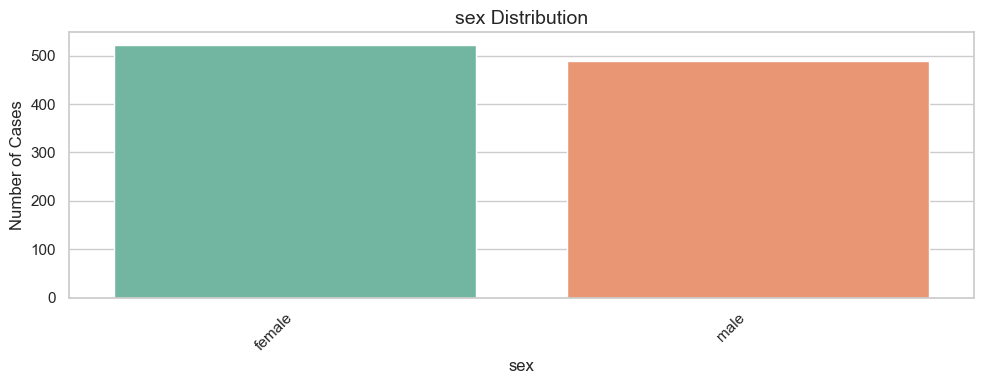

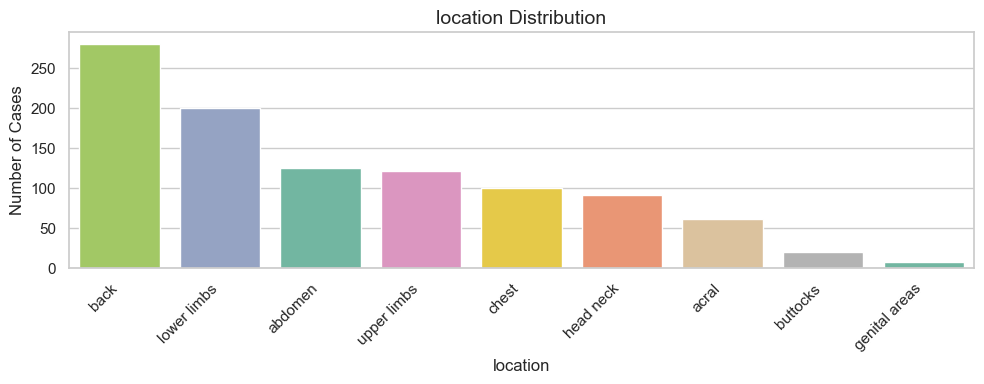

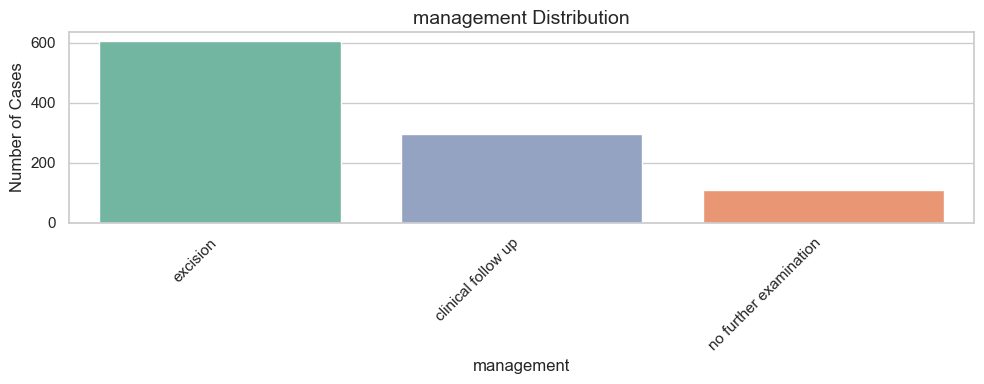

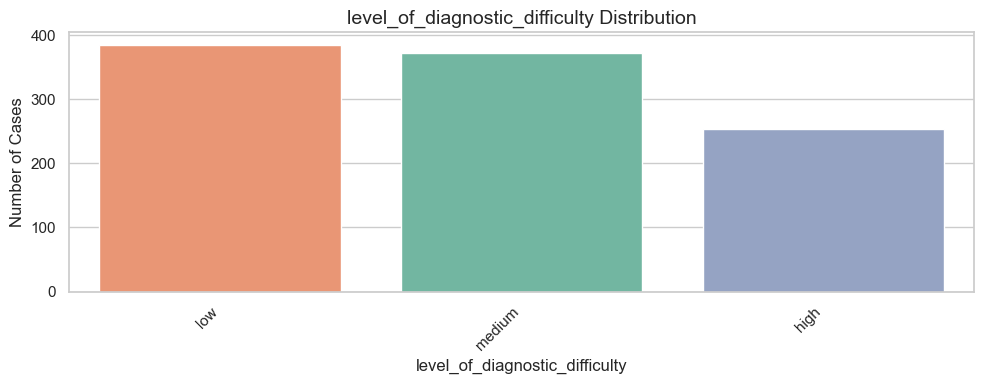

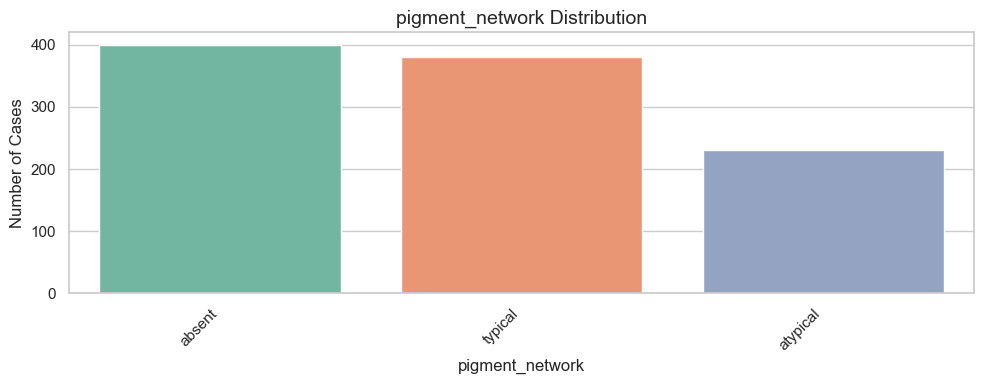

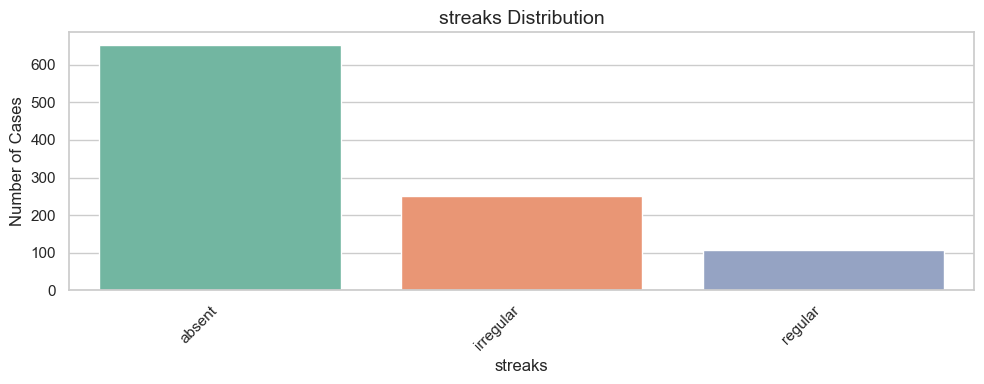

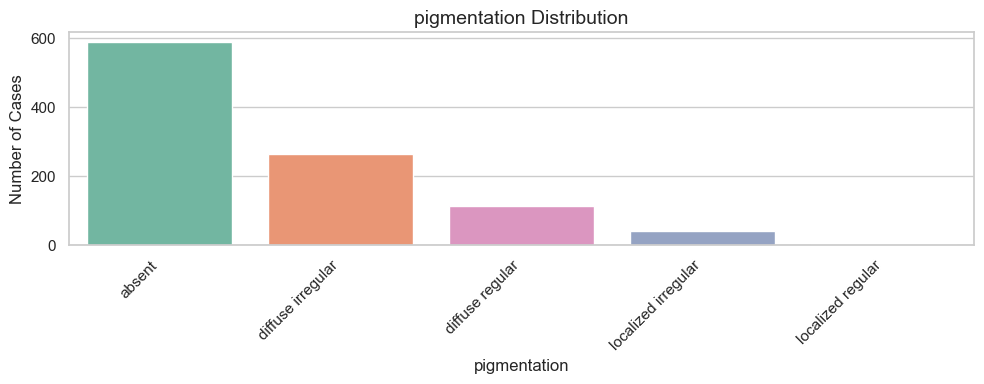

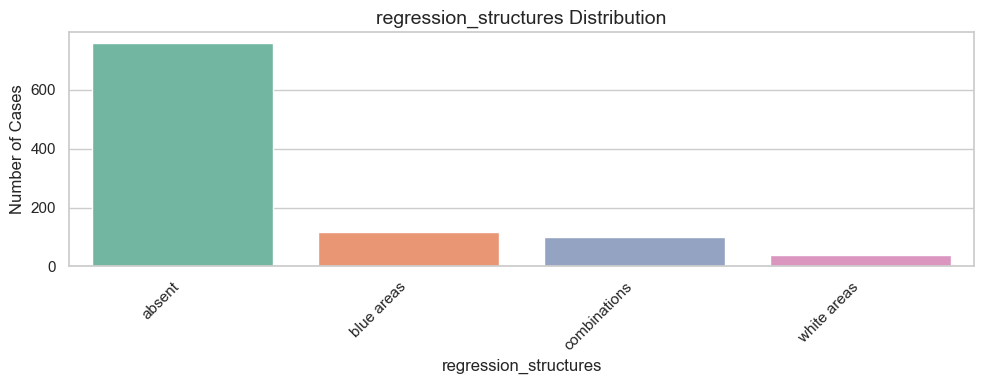

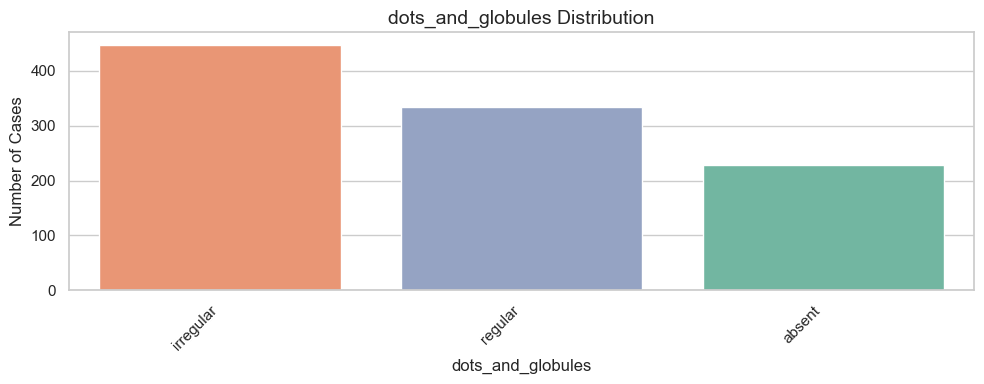

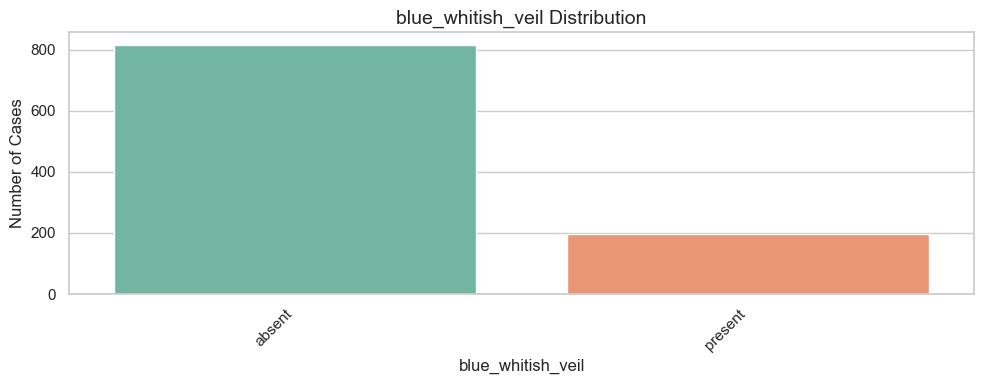

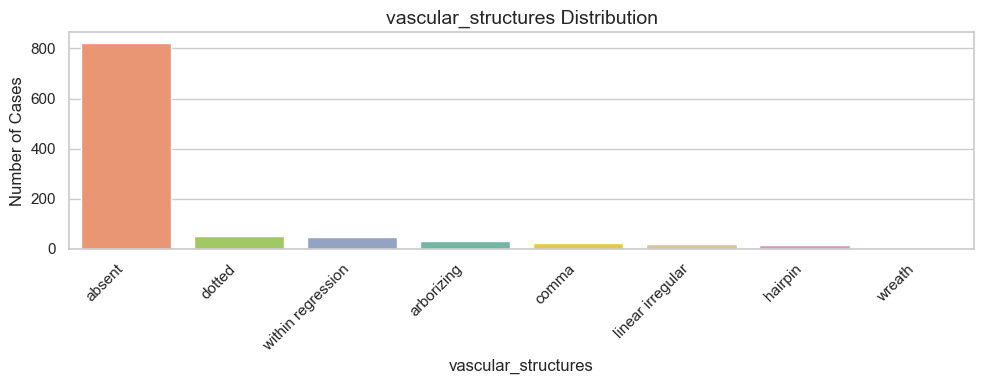

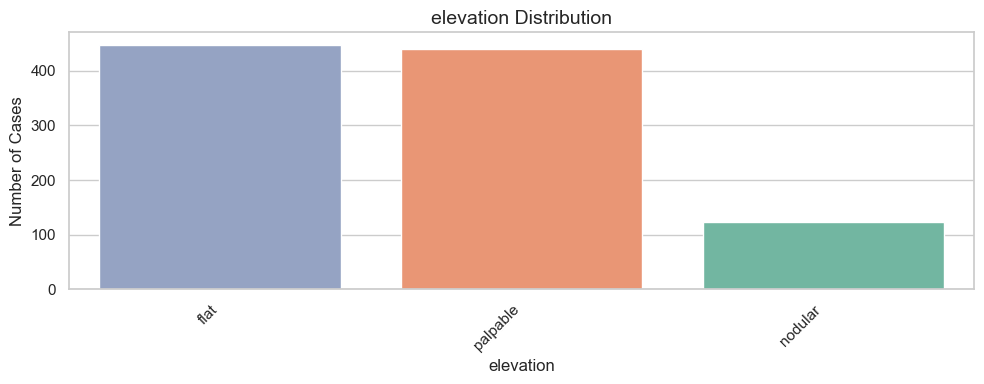

In [18]:
# Block 8: selected categorical distributions with labels and preserved palettes
cat_to_plot = [
    "sex", "location", "management", "level_of_diagnostic_difficulty",
    "pigment_network", "streaks", "pigmentation", "regression_structures",
    "dots_and_globules", "blue_whitish_veil", "vascular_structures", "elevation"
]

for c in cat_to_plot:
    if c in df.columns:
        plt.figure(figsize=(10, 4))
        order = df[c].value_counts().index
        num_categories = len(order)
        palette = sns.color_palette("Set2", n_colors=num_categories)
        sns.countplot(
            x=c,
            data=df,
            order=order,
            palette=palette,
            hue=c,
            dodge=False
        )
        plt.title(f"{c} Distribution", fontsize=14)
        plt.xlabel(c, fontsize=12)
        plt.ylabel("Number of Cases", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.legend([], [], frameon=False)
        plt.tight_layout()
        plt.show()


In [19]:
# Block 9: save canonical features and targets (no imputation)
exclude = [c for c in ["diagnosis", "image_path", "image_id", "case_id", "notes"] if c in df.columns]
features_cols = [c for c in df.columns if c not in exclude]
features_df = df[features_cols].copy()

object_cols = features_df.select_dtypes(include=["object"]).columns.tolist()
print("Object (categorical) columns retained in features.csv:", object_cols)

y_binary = df["diagnosis"].fillna("").apply(lambda x: 1 if x in melanoma_labels else 0)
y_multiclass = pd.get_dummies(df["diagnosis"].fillna("unknown"))

features_df.to_csv(CLEAN_FILE, index=False)
y_binary.to_frame("target_binary").to_csv(Y_BINARY_FILE, index=False)
y_multiclass.to_csv(Y_MULTI_FILE, index=False)

print("Saved canonical files:")
print(" - features:", CLEAN_FILE)
print(" - target binary:", Y_BINARY_FILE)
print(" - target multiclass:", Y_MULTI_FILE)


Object (categorical) columns retained in features.csv: ['pigment_network', 'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules', 'blue_whitish_veil', 'vascular_structures', 'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex', 'management', 'clinic', 'derm']
Saved canonical files:
 - features: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\features.csv
 - target binary: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\target_binary.csv
 - target multiclass: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\target_multiclass.csv


In [20]:
# Block 10: verification readback and summary
X_check = pd.read_csv(CLEAN_FILE)
y_binary_check = pd.read_csv(Y_BINARY_FILE)
y_multi_check = pd.read_csv(Y_MULTI_FILE)

print("Verification shapes after reload:")
print(" - features shape:", X_check.shape)
print(" - binary target shape:", y_binary_check.shape)
print(" - multiclass target shape:", y_multi_check.shape)
assert len(X_check) == len(y_binary_check) == len(y_multi_check), "Row mismatch detected!"
print("Row alignment OK.")

summary = {
    "n_rows": [len(df)],
    "n_features": [X_check.shape[1]],
    "n_numeric": [len(X_check.select_dtypes(include=[np.number]).columns)],
    "n_object": [len(X_check.select_dtypes(include=['object']).columns)],
    "n_missing_columns": [(X_check.isna().sum() > 0).sum()]
}
summary_df = pd.DataFrame(summary)
summary_df.to_csv(SUMMARY_FILE, index=False)

print("Saved dataset summary to:", SUMMARY_FILE)
print("\nEDA complete.")


Verification shapes after reload:
 - features shape: (1011, 16)
 - binary target shape: (1011, 1)
 - multiclass target shape: (1011, 20)
Row alignment OK.
Saved dataset summary to: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\dataset_summary.csv

EDA complete.


# Lab 2 – EDA and Cleaning (Summary & Executive Notes)

---

### Step‑by‑Step Summary

1. **Setup and Imports**  
   - Loaded pandas, numpy, seaborn, matplotlib.  
   - Defined dataset paths for reproducibility.  

2. **Data Loading**  
   - Read `meta.csv` into `df`.  
   - Inspected shape, dtypes, and non‑null counts.  
   - *Why:* Confirm schema and data quality.  

3. **Exploratory Data Analysis (EDA)**  
   - Checked class balance (`diagnosis`).  
   - Visualized distributions of numeric and categorical features.  
   - Plotted missing values.  
   - Correlation heatmap among numeric features.  
   - *Why:* Understand imbalance, feature coverage, and guide cleaning.  

4. **Cleaning Decisions**  
   - **Dropped Columns:**  
     - `case_id` → ~97% missing, identifier only.  
     - `notes` → ~99% missing, free‑text, not usable.  
   - Preserved `case_num` but excluded from scaling.  
   - *Why:* Avoid noise and target leakage.  

5. **Target Preparation**  
   - Kept raw `diagnosis`.  
   - Created `y_binary` (melanoma=1, others=0).  
   - Created `y_multiclass` (one‑hot encoded diagnosis).  
   - *Why:* Supports both binary and multiclass experiments.  

6. **Feature Engineering**  
   - One‑hot encoded categorical features (excluding `diagnosis`).  
   - Scaled numeric features (`seven_point_score`, etc.), excluding `case_num`.  
   - *Why:* Ensure features are numeric and standardized for models.  

7. **Saving Outputs**  
   - Saved:  
     - `features.csv` – cleaned, encoded, scaled feature matrix.  
     - `target_binary.csv` – binary labels (melanoma vs. benign/other).  
     - `target_multiclass.csv` – multiclass labels (20 categories).  
     - `metadata_cleaned.csv` – cleaned metadata table.  
   - Verified alignment: all outputs have consistent row counts.  

---

## Executive Summary – Lab 2 (EDA & Cleaning)

- **Objective:** Prepare Derm7pt metadata for modeling by exploring, cleaning, and transforming features into a machine‑learning‑ready format.  

- **Key Steps:**  
  - Inspected dataset structure, distributions, and missing values.  
  - Dropped sparse/non‑predictive columns (`case_id`, `notes`).  
  - One‑hot encoded categorical features; standardized numeric features.  
  - Created two target sets:  
    - **Binary target:** grouped all melanoma subtypes into class **1 (melanoma)**, and all other diagnoses into class **0 (benign/other)**.  
    - **Multiclass target:** one‑hot encoded all 20 diagnosis categories.  

- **Outputs:**  
  - `features.csv` – cleaned, encoded, scaled feature matrix.  
  - `target_binary.csv` – binary labels.  
  - `target_multiclass.csv` – multiclass labels.  
  - `metadata_cleaned.csv` – cleaned metadata table.  

- **Why it matters:** Establishes a reproducible, clean foundation for Lab 3 baselines (logistic regression, decision trees, etc.) and future multimodal fusion with images.  

---

**Status:** Lab 2 is complete. Next step: use `X` + `y_binary` for binary baselines, and `X` + `y_multiclass` for multiclass experiments in Lab 3.


---

## Key Findings – Lab 2 (EDA)

- **Class imbalance:** Melanoma cases form a minority compared to benign/other diagnoses, confirming the need for careful handling of imbalance in downstream models.  
- **Missingness concentrated:** `case_id` (~97% missing) and `notes` (~99% missing) were essentially unusable, while most other features had good coverage.  
- **Numeric features:** `seven_point_score` showed a skewed distribution, with most cases clustered at lower scores. Correlations among numeric features were weak, suggesting limited redundancy.  
- **Categorical distributions:** Features like `sex`, `location`, and `management` were unevenly distributed, with some categories dominating (e.g., certain body locations more frequent).  
- **Data integrity:** After cleaning and encoding, all feature and target files aligned perfectly in row counts, ensuring reproducibility for Lab 3.  

---

**conclusion:** The dataset is imbalanced but structurally sound after cleaning. With binary and multiclass targets prepared, the project is ready to progress into baseline modeling (Lab 3).
